In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import os, glob
import re
import datetime as dt

In [3]:
REANALYSIS_PATH = '/disks/arctic5_raid/abarrett/MERRA2/monthly'

FILENAME = {'SLP': 'MERRA2_???.tavgM_2d_slv_Nx.SLP.*.nc4',
            'U10M': '????/??/MERRA2_???.instM_2d_asm_Nx.U10M.*.nc4',
            'V10M': '????/??/MERRA2_???.instM_2d_asm_Nx.V10M.*.nc4'}


## Functions for ingest and processing

In [4]:
def get_fileList(varName):
    return glob.glob(os.path.join(REANALYSIS_PATH, varName, FILENAME[varName]))

def time_from_filename(fileList):
    p = re.compile('\d{6}')
    return [dt.datetime.strptime(p.search(f).group(),'%Y%m') for f in fileList]

def get_reanalysis(varName):
    
    fileList = get_fileList(varName)
    
    ds = xr.open_mfdataset( fileList, concat_dim='time')
    da = ds[varName].load()
    ds.close()
    if varName == 'SLP': 
        da = da * 1e-2 # convert to hPa
        da.attrs['units'] = 'hPa'

    if not 'time' in da.coords:
        da['time'] = time_from_filename(fileList)
        
    return da

def monAnom(x, year_begin='1981', year_end='2010'):
    """
    Calculates anomalies of x relative to the 1981-2010 period.

    N.B. Ideally, I would like to use an arbitrary mean field
    """
                                     
    def _anom(x):
        return x - x.sel(time=slice(year_begin,year_end)).mean(dim='time')

    return x.groupby('time.month').apply(_anom)
    
def get_oisst():
    
    SSTPATH = '/projects/arctic_scientist_data/NOAA_OISSTv2/sst/monthly'
    fileList = glob.glob( os.path.join( SSTPATH, 'sst.month.mean.????.v2.nc') )
    fileList.sort()
    #return fileList

    ds = xr.open_mfdataset(fileList, concat_dim='time')
    da = ds['sst'].load()
    ds.close()
    
    return da
    


## Get NOAA OISSTv2 data and calculate anomalies

In [5]:
sst = get_oisst()
sstAnom = monAnom(sst)
sstAnom

<xarray.DataArray 'sst' (time: 444, lat: 720, lon: 1440)>
array([[[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [-0.022456, -0.022811, ..., -0.022067, -0.022411],
        [-0.024755, -0.024755, ..., -0.024733, -0.024744]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [-0.036699, -0.036699, ..., -0.036645, -0.036677],
        [-0.036903, -0.036903, ..., -0.036903, -0.036903]],

       ...,

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [-0.444316, -0.444316, ..., -0.44426 , -0.444294],
        [-0.444027, -0.444027, ..., -0.444038, -0.444027]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [-0.372215, -0.372215, ..., -0.372182

## Get MERRA2 SLP and 10 m winds

In [6]:
slp = get_reanalysis('SLP')
u10m = get_reanalysis('U10M')
v10m = get_reanalysis('V10M')

Calculate SLP anomaly

In [7]:
slpAnom = monAnom(slp)
slpAnom

<xarray.DataArray 'SLP' (time: 451, lat: 361, lon: 576)>
array([[[ 1.125122,  1.125122, ...,  1.125122,  1.125122],
        [ 1.114807,  1.114502, ...,  1.115479,  1.115051],
        ...,
        [10.984924, 10.984314, ..., 10.986145, 10.985596],
        [10.707825, 10.707825, ..., 10.707825, 10.707825]],

       [[ 3.017578,  3.017578, ...,  3.017578,  3.017578],
        [ 3.161072,  3.160645, ...,  3.162354,  3.161865],
        ...,
        [-3.089417, -3.086792, ..., -3.094421, -3.09198 ],
        [-3.24408 , -3.24408 , ..., -3.24408 , -3.24408 ]],

       ...,

       [[-1.479797, -1.479797, ..., -1.479797, -1.479797],
        [-1.383728, -1.384644, ..., -1.382385, -1.382996],
        ...,
        [-3.689819, -3.688293, ..., -3.693298, -3.691589],
        [-3.573425, -3.573425, ..., -3.573425, -3.573425]],

       [[ 0.277954,  0.277954, ...,  0.277954,  0.277954],
        [ 0.246704,  0.245178, ...,  0.249573,  0.248047],
        ...,
        [-5.126648, -5.125366, ..., -5.128784,

Plot SLP, SLP anomaly and SST anomaly for 2007-09

In [8]:
68.+(10.2/60.)

68.17

In [9]:
def plot_slp_and_winds(slp, u, v, loc, map_proj, extent):
    """
    Plots SLP and winds
    """
    lats = u['lat']
    lons = u['lon']
    ua = u.values.squeeze()
    va = v.values.squeeze()
    
    h=np.shape(lats)[0]//2+1 # id for lat > 0
    
    ax = plt.subplot( loc, projection=map_proj )
    ax.set_extent( extent, ccrs.PlateCarree() )
    cax = slp.plot(ax=ax, transform=ccrs.PlateCarree(), 
                    levels=np.arange(994,1028,4),
                    cbar_kwargs={'orientation': 'horizontal',
                                 'label': 'hPa'})
    cax.colorbar.set_label('hPa', size=20)
    ax.quiver(lons, lats[h:-2], ua[h:-2,:],va[h:-2,:],
              transform=ccrs.PlateCarree(),regrid_shape=10, scale=100.)   
    ax.coastlines()
    ax.gridlines( xlocs=[0,150,180,210,359], ylocs=[40,60,80], linestyles='dotted')
    ax.set_title('SLP', fontsize=20)
    ax.plot(-168.968, 66.338, 'yo', transform=ccrs.PlateCarree(), ms=7, markeredgecolor='k') # Location of A3
    
    return ax

def plot_slp_anomaly(slpAnom, loc, map_proj, extent):
    """
    Plots SLP anomaly
    """
    ax = plt.subplot( loc, projection=map_proj )
    ax.set_extent( extent, ccrs.PlateCarree() )
    cax = slpAnom.plot(ax=ax, transform=ccrs.PlateCarree(), 
                       cmap='coolwarm',
                       cbar_kwargs={'orientation': 'horizontal',
                                    'label': 'hPa'})
    cax.colorbar.set_label('hPa', size=20)
    ax.coastlines()
    ax.gridlines( xlocs=[0,150,180,210,359], ylocs=[40,60,80], linestyles='dotted')
    ax.set_title('SLP Anomaly', fontsize=20)
    ax.plot(-168.968, 66.338, 'yo', transform=ccrs.PlateCarree(), ms=7, markeredgecolor='k') # Location of A3

    return ax

def plot_sst_anomaly(sstAnom, loc, map_proj, extent):
    """
    Plots SST anomaly
    """
    ax = plt.subplot( loc, projection=map_proj )
    ax.set_extent( extent, ccrs.PlateCarree())
    cax = sstAnom.sel(lat=slice(30,90), lon=slice(90,270)).plot(ax=ax,
                                                                 transform=ccrs.PlateCarree(), vmin=-3, vmax=3, 
                                                                 cmap='coolwarm', 
                                                                 cbar_kwargs={'orientation': 'horizontal',
                                                                              'label': 'K'})
    cax.colorbar.set_label('K', size=20)
    ax.add_feature( cfeature.LAND )
    ax.gridlines( xlocs=[0,150,180,210,359], ylocs=[40,60,80], linestyles='dotted')
    ax.set_title('SST', fontsize=20);
    ax.plot(-168.968, 66.338, 'yo', transform=ccrs.PlateCarree(), ms=7, markeredgecolor='k') # Location of A3

    return ax

In [41]:
def plot_case_study(slp, slpAnom, sstAnom, date, filo=None, winds=None):
    """
    Plots 3-panel figure of case study month
    """
    
    fig = plt.figure(figsize=(20, 7))
    
    # Set up map projection and extent
    map_proj = ccrs.NorthPolarStereo(central_longitude=180.)
    extent = [150.,210.,40.,90.]
    
    ax = []
    
    # Plot SLP
    ax.append( plot_slp_and_winds( slp.sel(time=date), u10m.sel(time=date), v10m.sel(time=date), 
                                   131, map_proj, extent) )
    # Plot SLP Anomaly
    ax.append( plot_slp_anomaly(slpAnom.sel(time=date), 132, map_proj, extent) )
    # Plot SST Anomaly
    ax.append( plot_sst_anomaly(sstAnom.sel(time=date), 133, map_proj, extent ) )
    
    if winds:
        plt.figtext(0.24, 0.3, 'V(BS)={:4.1f}, U(ESS)={:4.1f}, U(BSS)={:4.1f}'.format(*winds), 
                    fontsize=15, horizontalalignment='center')
    
    filo = 'case_study_{:s}.png'.format(dt.datetime.strptime(date,'%Y-%m').strftime('%Y%m'))
    fig.savefig(filo)

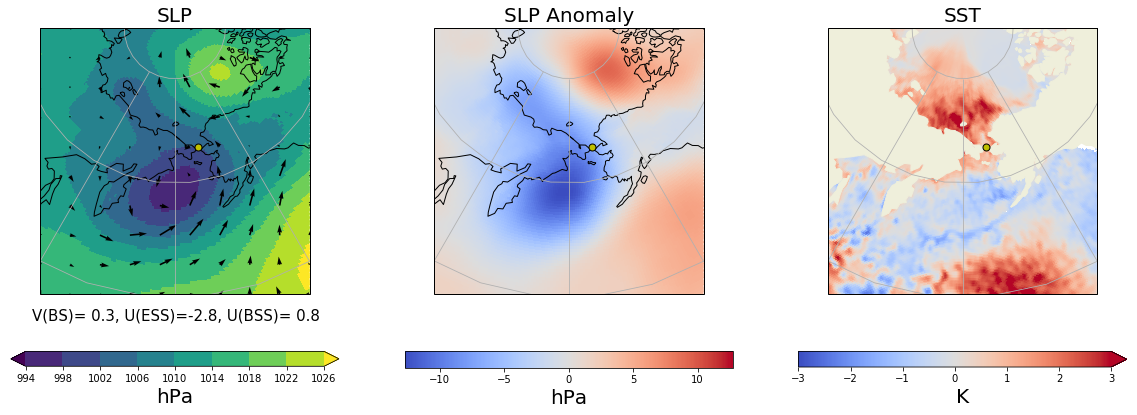

In [42]:
plot_case_study(slp, slpAnom, sstAnom, '2007-09', winds=[0.345, -2.811, 0.836])

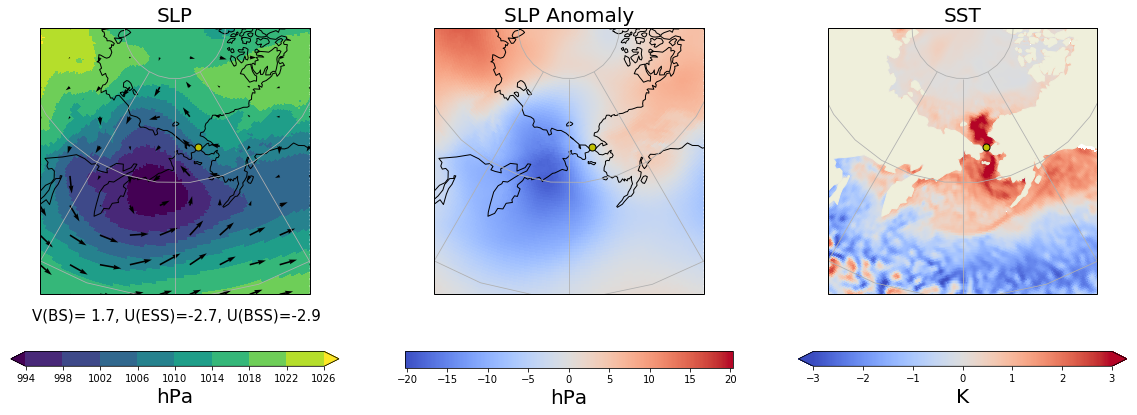

In [43]:
plot_case_study(slp, slpAnom, sstAnom, '2016-10', winds=[1.725, -2.698, -2.868])

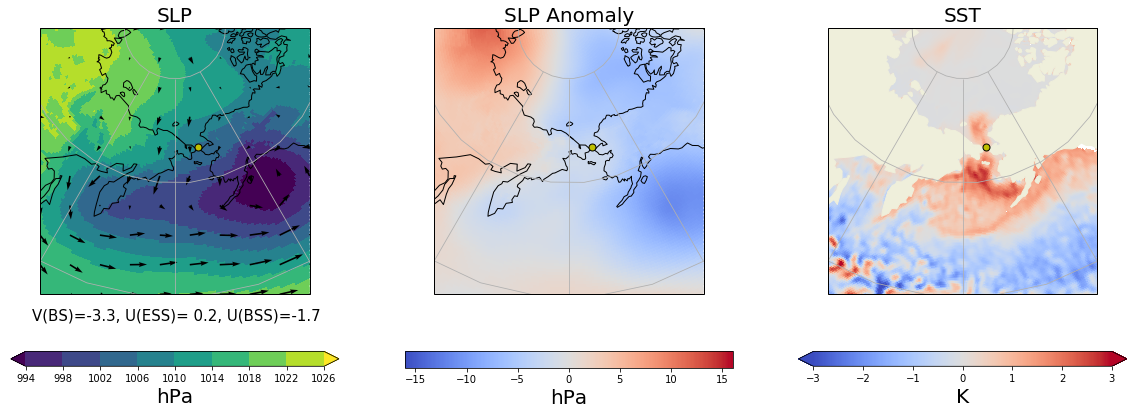

In [44]:
plot_case_study(slp, slpAnom, sstAnom, '2016-11', winds=[-3.274, 0.250, -1.730])

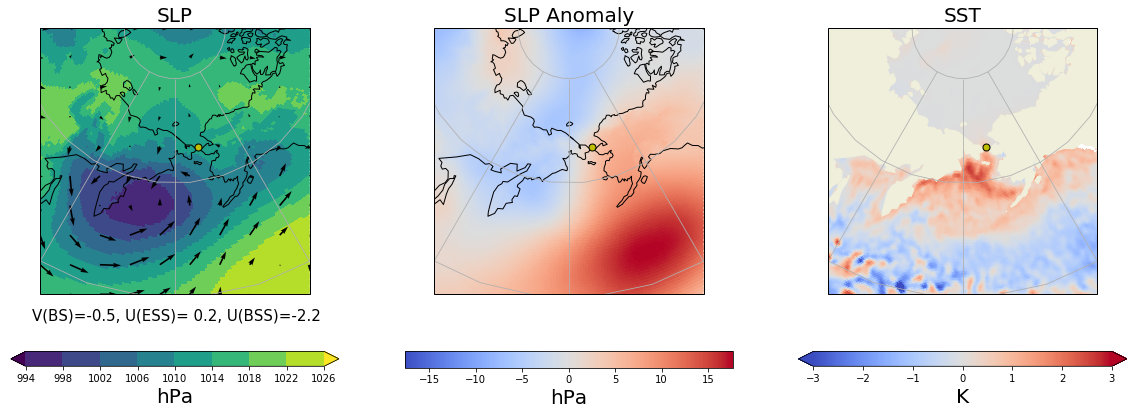

In [45]:
plot_case_study(slp, slpAnom, sstAnom, '2016-12', winds=[-0.490, 0.195, -2.184])

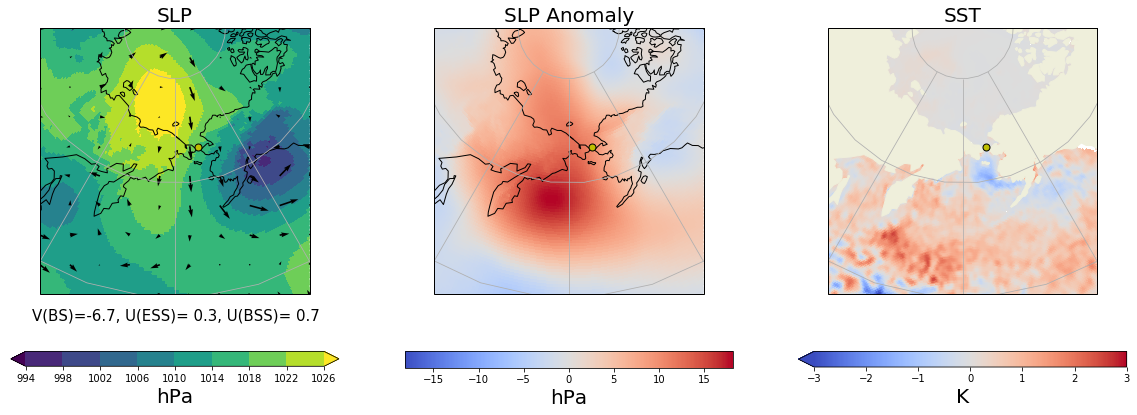

In [46]:
plot_case_study(slp, slpAnom, sstAnom, '2005-11', winds=[-6.686, 0.298, 0.684])